In [16]:
import warnings
from helper import *

In [17]:
warnings.filterwarnings("ignore")

In [18]:
file_dict, file_dir, master_dir = get_data_files()

In [19]:
master_df = pd.DataFrame()

In [20]:
# get the file indexes
available_file_indexes = [{a: [c.split("_")[0][2:] for c in sorted(b)]} for a, b in file_dict.items()]
available_file_indexes = {k: v for d in available_file_indexes for k, v in d.items()}

In [21]:
# sort the file_dict by the file name number
for year, files in file_dict.items():
    file_dict[year] = sorted(files, key=lambda x: int(x.split("_")[0][2:]))

In [22]:
# find top 20 pipes for every file
for year, files in file_dict.items():
    access_index = 0
    for index in available_file_indexes[year]:
        master_df = find_common_pipes(file_index=access_index, file_year=year, top_level_df=master_df,
                                      file_dict=file_dict, master_dir=master_dir)
        access_index += 1

In [23]:
# transpose the dataframe
master_df_T = master_df.copy().T
master_df_T.columns, master_df_T.loc["X", :] = master_df_T.loc[["X"], :].values[0], master_df_T.columns

In [24]:
# create multilevel columns
exp_df = pd.DataFrame(columns=pd.MultiIndex.from_product([master_df_T.columns, ["Pipe TTNr", "Total"]]).unique())

In [25]:
# add the data to the multilevel columns
for i in range(len(master_df_T)):
    exp_df.loc[i, :] = master_df_T.iloc[i, :].values

In [26]:
# drop the unnecessary index
exp_df = exp_df.copy().drop(index=0, inplace=False)

In [27]:
# save or create the Excel file
exp_df.to_excel(file_dir, sheet_name="General")

In [28]:
# create multi-level index
three_level_columns = create_three_level_index(df=exp_df)

# set the multi-level index
exp_df.columns = pd.MultiIndex.from_tuples(three_level_columns)

In [29]:
# format the Excel file
format_excel_file(file_dir=file_dir)

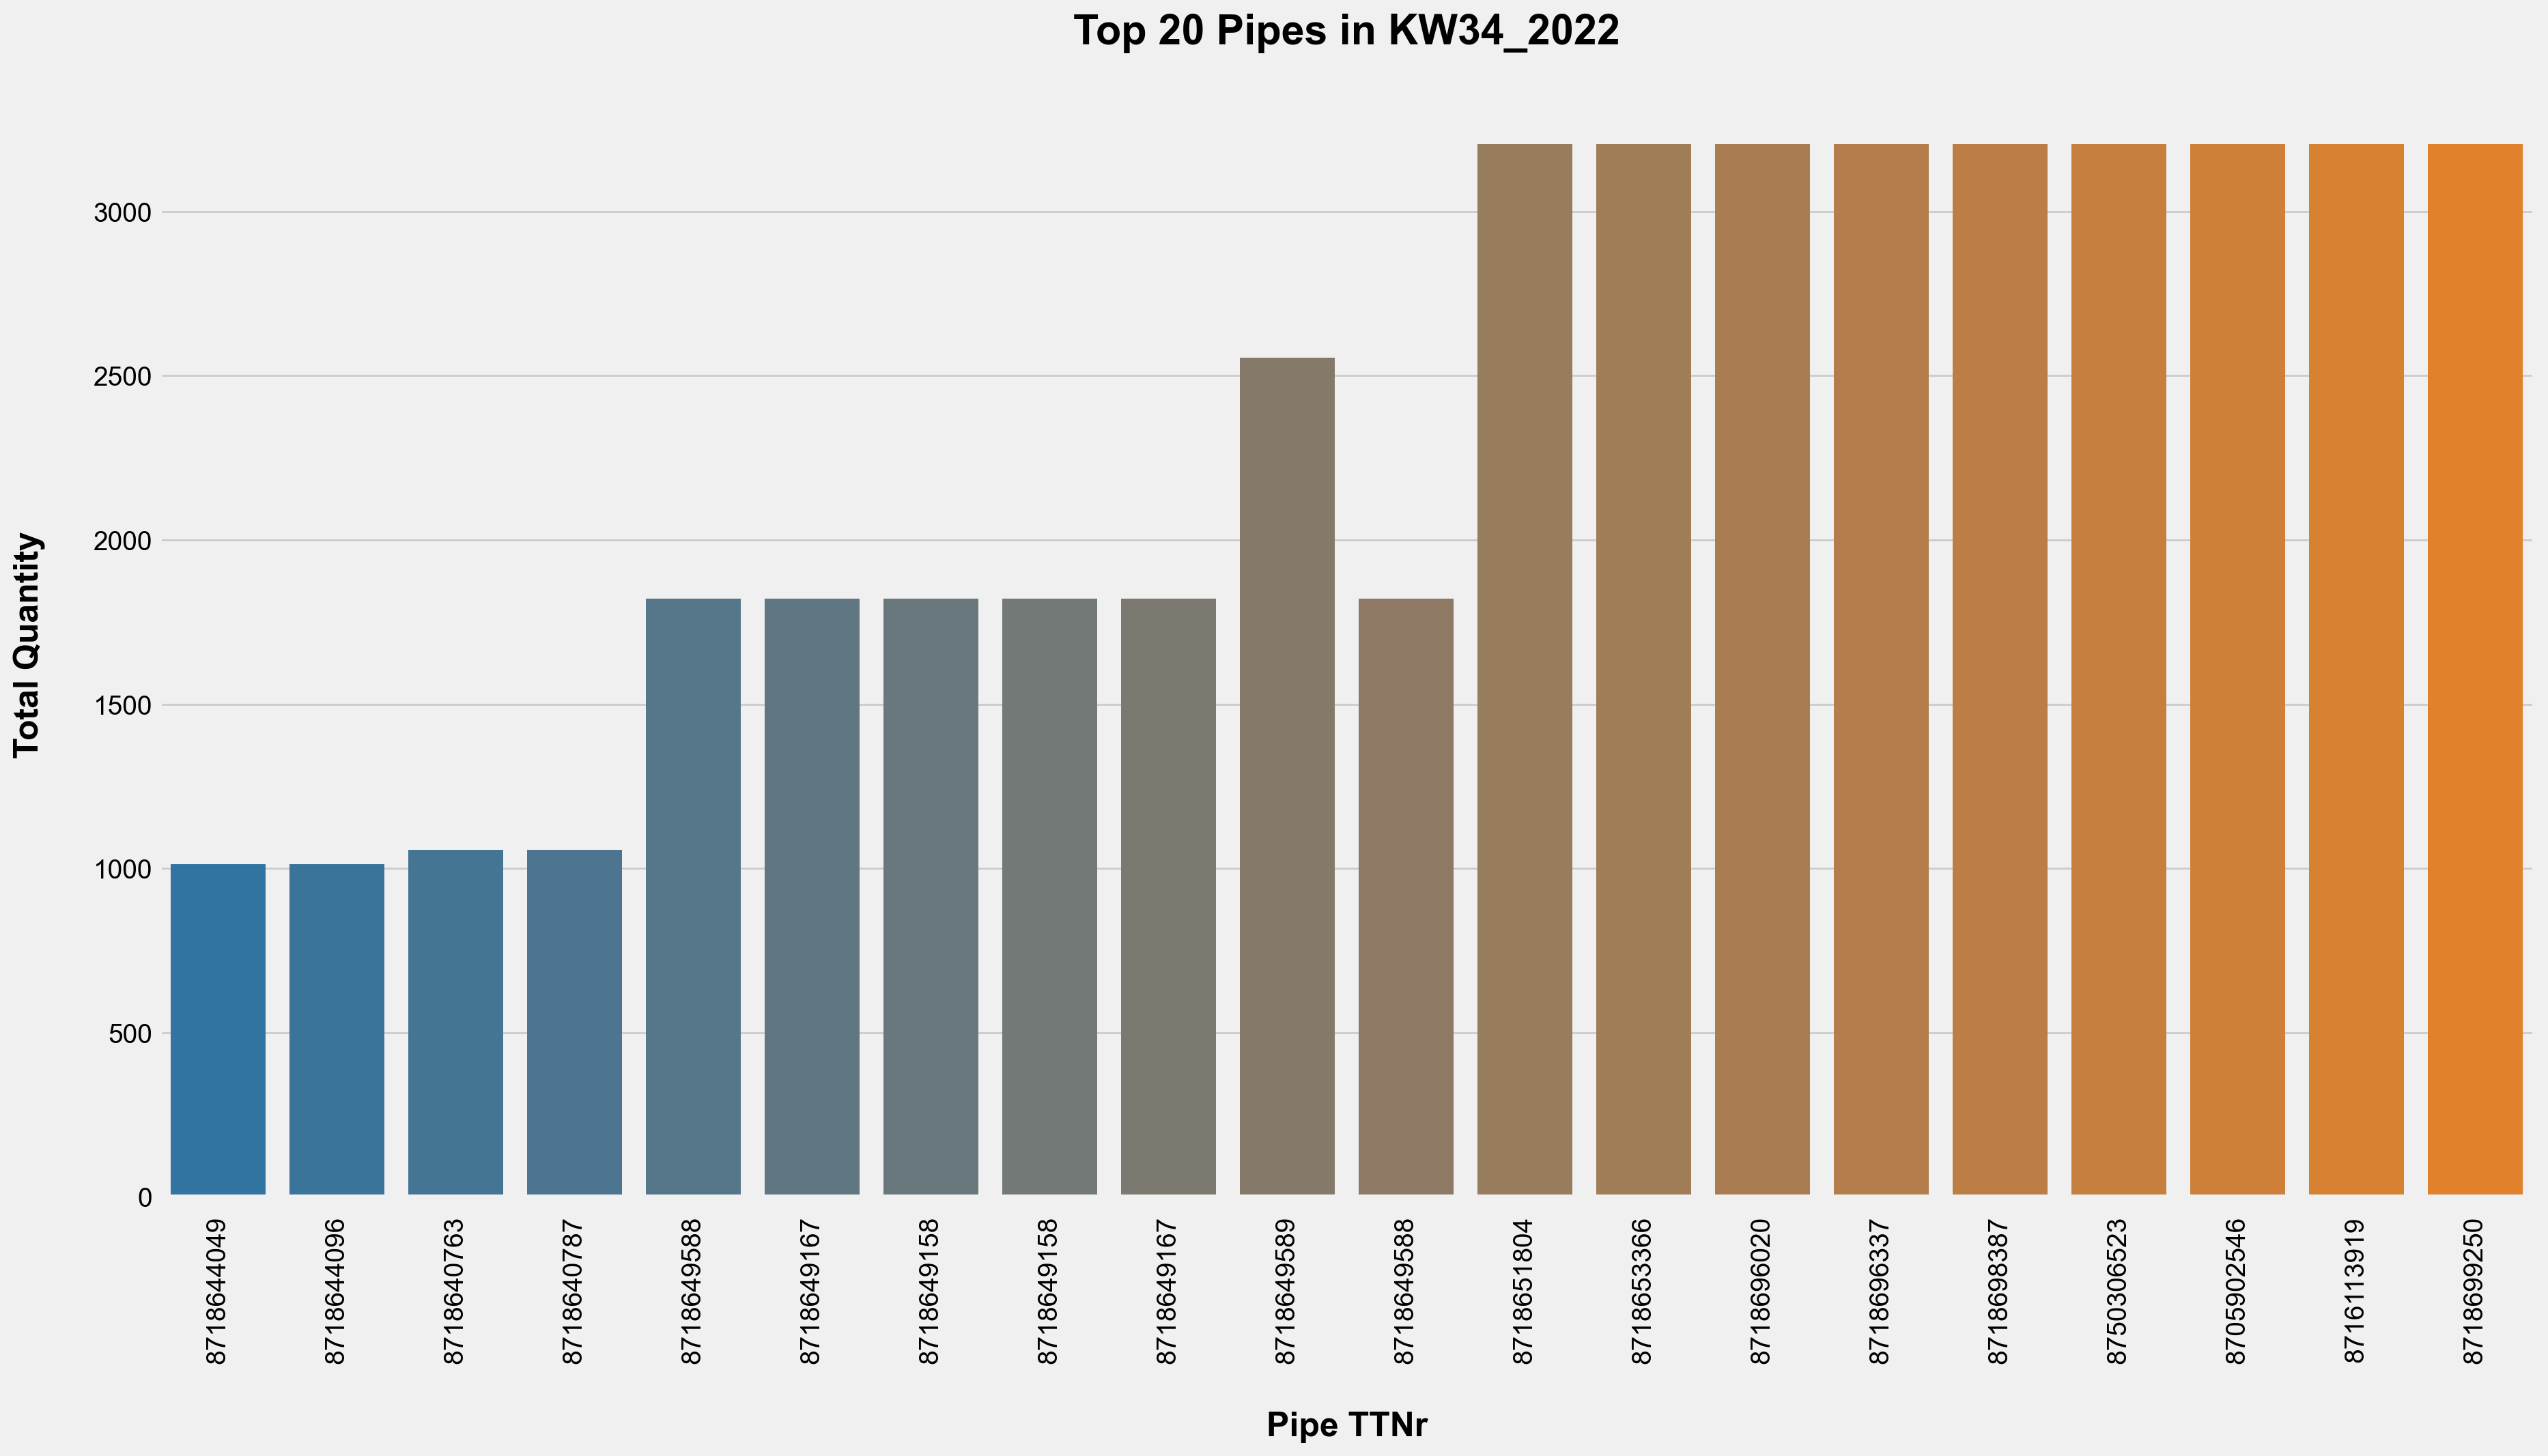

In [31]:
create_bar_plot(df=exp_df, selected_year=2022, file_index=34)